# ECCOv4 Global Heat Budget Closure
**Jan-Erik Tesdal<sup>1,*</sup>, Ryan Abernathey<sup>1</sup> and Ian Fenty<sup>2</sup>**
<br>
<sup>1</sup> Lamont-Doherty Earth Observatory, Columbia University, Palisades, NY, USA
<br>
<sup>2</sup> Jet Propulsion Laboratory, California Institute of Technology, Pasadena, CA, USA
<br>
<sup>*</sup>*Corresponding author*: jt2796@columbia.edu

This section demonstrates the closure of the global heat budget in ECCOv4. The steps and Python code has been directly derived from the calculations and MATLAB code in "*A Note on Practical Evaluation of Budgets in ECCO Version 4 Release 3"* by Christopher G. Piecuch (https://ecco.jpl.nasa.gov/drive/files/Version4/Release3/doc/v4r3_budgets_howto.pdf).

## Objectives

Evaluating and closing the heat budget over the global ocean. 

## Introduction

The ocean heat content (OHC) variability is described here with potential temperature ($\theta$) which is given by the ECCOv4 diagnostic output `THETA`. The budget equation describing the change in $\theta$ is evaluated in general as

\begin{equation}
\frac{\partial \theta}{\partial t} = -\nabla \cdot (\theta \mathbf{u})-\nabla\cdot\mathbf{F}_\textrm{diff}^{\theta}+{F}_\textrm{forc}^{\theta}
\end{equation}

The heat budget includes the change in temperature over time ($\frac{\partial \theta}{\partial t}$), the convergence of heat advection ($-\nabla \cdot (\theta \mathbf{u})$) and heat diffusion ($-\nabla\cdot\mathbf{F}_\textrm{diff}$), plus downward heat flux from the atmosphere (${F}_\textrm{forc}$). Note that in our definition ${F}_\textrm{forc}$ contains both latent and sensible air-sea heat fluxes, longwave and shortwave radiation, as well as geothermal heat flux.

In the special case of ECCOv4, the heat budget is formulated as
\begin{equation}
\underbrace{\frac{\partial(s^*\theta)}{\partial t}}_{G^{\theta}_\textrm{total}} = \underbrace{-\nabla_{z^{*}} \cdot(s^*\theta\,\mathbf{v}_{res}) - \frac{\partial(\theta\,w_{res})}{\partial z^{*}}}_{G^{\theta}_\textrm{advection}}\underbrace{- s^* ({\nabla\cdot\mathbf{F}_\textrm{diff}^{\theta}})}_{G^{\theta}_\textrm{diffusion}} + \underbrace{s^* {F}_\textrm{forc}^{\theta}}_{G^{\theta}_\textrm{forcing}}
\end{equation}

where $z^{*} = \frac{z - \eta}{H + \eta}H$ and $\nabla_{z^{*}}$/$\frac{\partial}{\partial z^{*}}$ are horizontal/vertical divergences in the $z^*$ frame. Also note that the advection is now separated into horizontal ($\mathbf{v}_{res}$) and vertical ($w_{res}$) components, and there is a scaling factor ($s^* = 1+ \frac{\eta}{H}$) applied to the horizontal advection as well as the diffusion term ($G^{\theta}_\textrm{diffusion}$) and forcing term ($G^{\theta}_\textrm{forcing}$). $s^*$ is a function of $\eta$ which is the displacement of the ocean surface from its resting position of $z=0$ (i.e., sea height anomaly). $H$ is the ocean depth. $s^{*}$ comes from the coordinate transformation from z to $z^*$ (Campin and Adcroft, 2004; Campin et al., 2004). See [ECCOv4 Global Volume Budget Closure](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Volume_budget_closure.html#ECCOv4-Global-Volume-Budget-Closure) for a more detailed explanation of the $z^*$ coordinate system.

Note that the velocity terms in the ECCOv4 heat budget equation ($\mathbf{v}_{res}$ and $w_{res}$) are described as the "residual mean" velocities, which contain both the resolved (Eulerian) flow field, as well as the "GM bolus" velocity (i.e., parameterizing unresolved eddy effects):

$$(u_{res},v_{res},w_{res})= (u,v,w)+ (u_b,v_b,w_b)$$

Here $(u_b,v_b,w_b)$ is the bolus velocity parameter, taking into account the correlation between velocity and thickness (also known as the eddy induced transportor the eddy advection term).

## Evaluating the heat budget

We will evalute each term in the above heat budget 

$$G^{\theta}_\textrm{total} = G^{\theta}_\textrm{advection} + G^{\theta}_\textrm{diffusion} + G^{\theta}_\textrm{forcing}$$

The total tendency of $\theta$ ($G^{\theta}_\textrm{total}$) is the sum of the $\theta$ tendencies from advective heat convergence ($G^{\theta}_\textrm{advection}$), diffusive heat convergence ($G^{\theta}_\textrm{diffusion}$) and total forcing ($G^{\theta}_\textrm{forcing}$). 

We present calculation sequentially for each term starting with $G^{\theta}_\textrm{total}$ which will be derived by differencing instantaneous monthly snapshots of $\theta$. The terms on the right hand side of the heat budget are derived from monthly-averaged fields.

## Prepare environment and load ECCOv4 diagnostic output

### Import relevant Python modules

In [ ]:
# import numpy as np
import xarray as xr

In [2]:
# Suppress warning messages for a cleaner presentation
import warnings
warnings.filterwarnings('ignore')

In [3]:
## Import the ecco_v4_py library into Python
## =========================================

## -- If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.

#import sys
#sys.path.append('/home/username/ECCOv4-py')

import ecco_v4_py as ecco

In [4]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

### Add relevant constants

In [5]:
# Seawater density (kg/m^3)
rhoconst = 1029
## needed to convert surface mass fluxes to volume fluxes

# Heat capacity (J/kg/K)
c_p = 3994

# Constants for surface heat penetration (from Table 2 of Paulson and Simpson, 1977)
R = 0.62
zeta1 = 0.6
zeta2 = 20.0

### Load ecco_grid

In [6]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================

# Define main directory
base_dir = '/home/username/ECCOv4-release'

# Define ECCO version
ecco_version = 'v4r3'
    
# Define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/Release3_alt'

> **Note**: Change `base_dir` to your own directory path.

In [7]:
# Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc')

### Volume
Calculate the volume of each grid cell. This is used when converting advective and diffusive flux convergences and calculating volume-weighted averages.

In [8]:
# Volume (m^3)
vol = (ecco_grid.rA*ecco_grid.drF*ecco_grid.hFacC).transpose('tile','k','j','i')

### Load monthly snapshots

In [9]:
data_dir= ECCO_dir + '/nctiles_monthly_snapshots'

year_start = 1993
year_end = 2017

# Load one extra year worth of snapshots
ecco_monthly_snaps = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                         vars_to_load=['ETAN','THETA'],\
                         years_to_load=range(year_start, year_end+1))

num_months = len(ecco_monthly_snaps.time.values)
# Drop the last 11 months so that we have one snapshot at the beginning and end of each month within the 
# range 1993/1/1 to 2015/1/1

ecco_monthly_snaps = ecco_monthly_snaps.isel(time=np.arange(0, num_months-11))

loading files of  ETAN
loading files of  THETA


In [10]:
# 1993-01 (beginning of first month) to 2015-01-01 (end of last month, 2014-12)
print(ecco_monthly_snaps.ETAN.time.isel(time=[0, -1]).values)

['1993-01-01T00:00:00.000000000' '2015-01-01T00:00:00.000000000']


In [11]:
# Find the record of the last snapshot
## This is used to defined the exact period for monthly mean data 
last_record_date = ecco.extract_yyyy_mm_dd_hh_mm_ss_from_datetime64(ecco_monthly_snaps.time[-1].values)
print(last_record_date)

(2015, 1, 1, 0, 0, 0)


### Load monthly mean data 

In [12]:
data_dir= ECCO_dir + '/nctiles_monthly'

year_end = last_record_date[0]
ecco_monthly_mean = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                        vars_to_load=['TFLUX','oceQsw','ADVx_TH','ADVy_TH','ADVr_TH',
                                      'DFxE_TH','DFyE_TH','DFrE_TH','DFrI_TH'],\
                        years_to_load=range(year_start, year_end))

loading files of  ADVr_TH
loading files of  ADVx_TH
loading files of  ADVy_TH
loading files of  DFrE_TH
loading files of  DFrI_TH
loading files of  DFxE_TH
loading files of  DFyE_TH
loading files of  TFLUX
loading files of  oceQsw


In [13]:
# Print first and last time points of the monthly-mean records
print(ecco_monthly_mean.time.isel(time=[0, -1]).values)

['1993-01-16T12:00:00.000000000' '2014-12-16T12:00:00.000000000']


Each monthly mean record is bookended by a snapshot. We should have one more snapshot than monthly mean record.

In [14]:
print('Number of monthly mean records: ', len(ecco_monthly_mean.time))
print('Number of monthly snapshot records: ', len(ecco_monthly_snaps.time))

Number of monthly mean records:  264
Number of monthly snapshot records:  265


In [15]:
# Drop superfluous coordinates (We already have them in ecco_grid)
ecco_monthly_mean = ecco_monthly_mean.reset_coords(drop=True)

### Create the xgcm 'grid' object

The xgcm grid object is helpful to do flux divergence calculations across different tiles of the lat-lon-cap grid.

In [16]:
grid = ecco.get_llc_grid(ecco_grid)

## Calculate total tendency of $\theta$ ($G^{\theta}_\textrm{total}$)

We calculate the monthly-averaged time tendency of ``THETA`` by differencing monthly ``THETA`` snapshots. Remember  that we need to include a scaling factor due to the nonlinear free surface formulation. Thus, we need to use snapshots of both `ETAN` and `THETA`  to evaluate $s^*\theta$.

In [17]:
# Calculate the s*theta term
sTHETA = ecco_monthly_snaps.THETA*(1+ecco_monthly_snaps.ETAN/ecco_grid.Depth)

In [18]:
num_months = len(ecco_monthly_snaps.time)

G_total_tendency_month = sTHETA.isel(time=range(1,num_months)).values - sTHETA.isel(time=range(0,num_months-1)).values

# The result is a numpy array of 264 months
print('Shape of G_total_tendency_month: ', G_total_tendency_month.shape)

Shape of G_total_tendency_month:  (264, 13, 50, 90, 90)


In [19]:
# Convert numpy array to an xarray DataArray with matching dimensions as the monthly mean fields
G_total_tendency_month = xr.DataArray(G_total_tendency_month,coords={'time': ecco_monthly_mean.time.values,
                                                                     'tile': ecco_monthly_mean.tile.values,
                                                                     'k': ecco_monthly_mean.k.values,
                                                                     'j': ecco_monthly_mean.j.values,
                                                                     'i': ecco_monthly_mean.i.values},
                                      dims=['time','tile','k','j','i'])

The nice thing is that now the time values of `G_total_tendency_month` line up with the time values of the time-mean fields (middle of the month)

In [20]:
print('Time of first array in G_total_tendency_month:');
print(G_total_tendency_month.time[0].values)

Time of first array in G_total_tendency_month:
1993-01-16T12:00:00.000000000


Now convert tendency from 1/month to 1/second by dividing with the number of seconds in each month. To find the number of seconds in each month, subtract the model time step number (which is hourly) from the beginning and end of each month:

In [21]:
if ecco_version == 'v4r4':
    hrs_per_month = ecco_monthly_snaps.timestep[1:].values - \
    ecco_monthly_snaps.timestep[0:-1].values
elif ecco_version == 'v4r3':
    hrs_per_month = ecco_monthly_snaps.iter[1:].values - \
    ecco_monthly_snaps.iter[0:-1].values

# Convert hours per month to seconds per month:
secs_per_month = hrs_per_month * 3600

# Make a DataArray with the number of seconds in each month, 
#time indexed to the times in dETAN_dT_perMonth (middle of each month)
secs_per_month = xr.DataArray(secs_per_month, \
                              coords={'time': G_total_tendency_month.time.values}, \
                              dims='time')

# Show number of seconds in the first two months:
print('Number of seconds in Jan and Feb 1993 ', secs_per_month[0:2].values)

# Sanity check: show number of days in the first two months:
print('Number of days in Jan and Feb 1993 ', secs_per_month[0:2].values/3600/24)

Number of seconds in Jan and Feb 1993  [2678400 2419200]
Number of days in Jan and Feb 1993  [31. 28.]


Convert the `ns_in_month` from timedelta64 object to float so we can use it to use it for a mathematical operation: converting `G_total_tendency_month` to `G_total_tendency`.  Also, convert from ns to seconds.

In [22]:
# Convert perMonth to perSecond
G_total_tendency = G_total_tendency_month / secs_per_month

### Plot the time-mean $\partial \theta / \partial t$, total $\Delta \theta$, and one example $\partial \theta / \partial t$ field

####  Time-mean $\partial \theta / \partial t$
The time-mean $\partial \theta / \partial t$ (i.e., $\overline{G^{\theta}_\textrm{total}}$), is given by 

$\overline{G^{\theta}_\textrm{total}} = \sum_{i=1}^{nm} w_i G^{\theta}_\textrm{total}$

with $\sum_{i=1}^{nm} w_i = 1$ and  nm=number of months

In [23]:
# The weights are just the number of seconds per month divided by total seconds
month_length_weights = secs_per_month / secs_per_month.sum()

In [24]:
# The weighted mean weights by the length of each month (in seconds)
G_total_tendency_mean = (G_total_tendency*month_length_weights).sum('time')

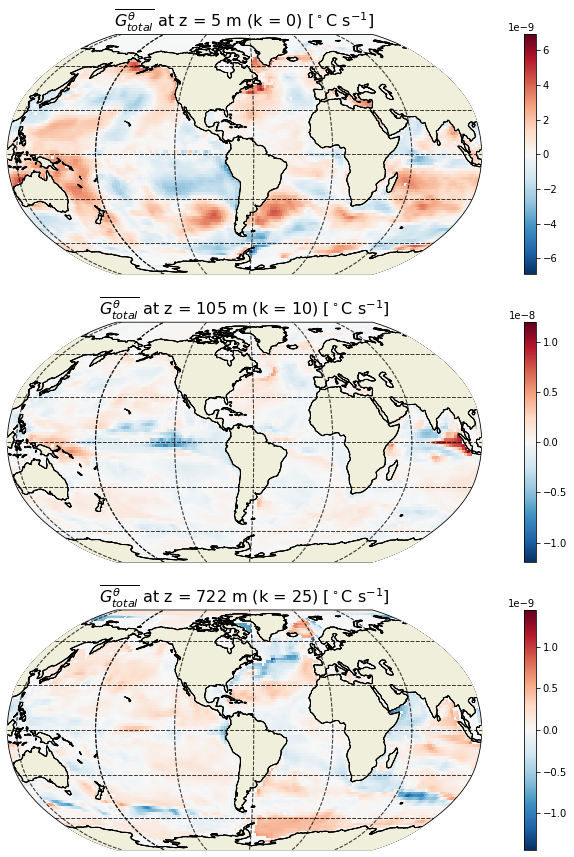

In [25]:
plt.figure(figsize=(15,15))

for idx, k in enumerate([0,10,25]):
    p = ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, G_total_tendency_mean[:,k],show_colorbar=True,
                                      cmap='RdBu_r', user_lon_0=-67, dx=2,dy=2, subplot_grid=[3,1,idx+1]);
    p[1].set_title(r'$\overline{G^\theta_{total}}$ at z = %i m (k = %i) [$^\circ$C s$^{-1}$]'\
                   %(np.round(-ecco_grid.Z[k].values),k), fontsize=16)

#### Total $\Delta \theta$

How much did ``THETA`` change over the analysis period?

In [26]:
# The number of seconds in the entire period 
seconds_in_entire_period = \
    float(ecco_monthly_snaps.time[-1] - ecco_monthly_snaps.time[0])/1e9
print ('seconds in analysis period: ', seconds_in_entire_period)

# which is also the sum of the number of seconds in each month
print('sum of seconds in each month ', secs_per_month.sum().values)

seconds in analysis period:  694224000.0
sum of seconds in each month  694224000


In [27]:
THETA_delta = G_total_tendency_mean*seconds_in_entire_period

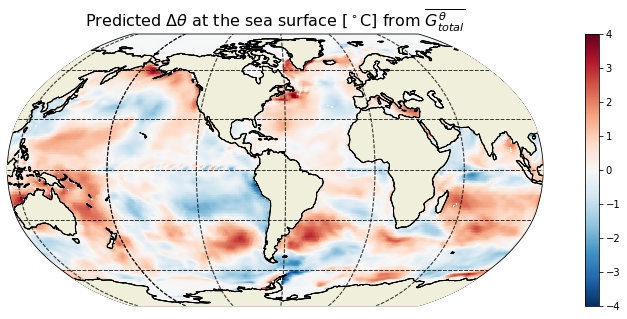

In [28]:
plt.figure(figsize=(15,5));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                              THETA_delta[:,0],show_colorbar=True,\
                              cmin=-4, cmax=4, \
                              cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2);
plt.title(r'Predicted $\Delta \theta$ at the sea surface [$^\circ$C] from $\overline{G^\theta_{total}}$',fontsize=16);

We can sanity check the total ``THETA`` change that we found by multipling the time-mean ``THETA`` tendency with the number of seconds in the simulation by comparing that with the difference in ``THETA`` between the end of the last month and start of the first month. 

In [29]:
THETA_delta_method_2 = ecco_monthly_snaps.THETA.isel(time=-1) - ecco_monthly_snaps.THETA.isel(time=0)

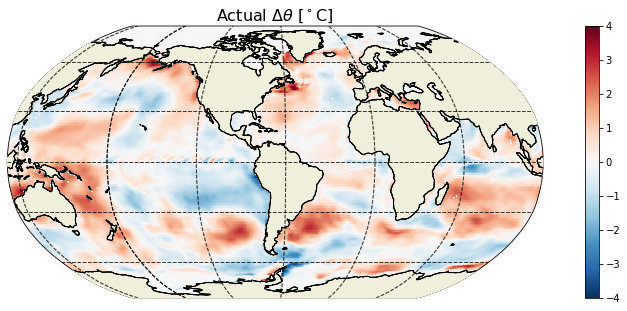

In [30]:
plt.figure(figsize=(15,5));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                              THETA_delta_method_2[:,0],show_colorbar=True,\
                              cmin=-4, cmax=4, \
                              cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2);
plt.title(r'Actual $\Delta \theta$ [$^\circ$C]', fontsize=16);

#### Example $G^\theta_{total}$ field at a particular time

(2001, 5, 16, 12, 0, 0)


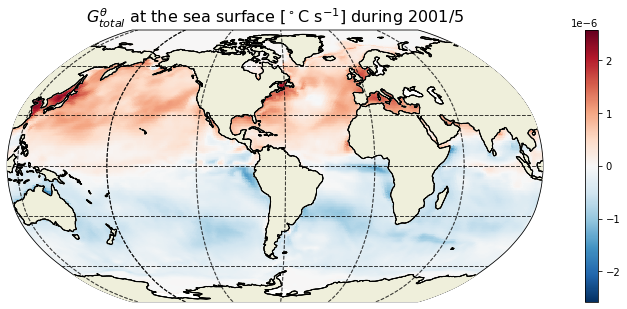

In [31]:
plt.figure(figsize=(15,5));

# get an array of YYYY, MM, DD, HH, MM, SS for 
#dETAN_dT_perSec at time index 100
tmp = ecco.extract_yyyy_mm_dd_hh_mm_ss_from_datetime64(G_total_tendency.time[100].values)
print(tmp)
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                              G_total_tendency.isel(time=100)[:,0],\
                              show_colorbar=True,\
                              cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2);

plt.title(r'$G^\theta_{total}$ at the sea surface [$^\circ$C s$^{-1}$] during ' + 
          str(tmp[0]) +'/' + str(tmp[1]), fontsize=16);

For any given month the time rate of change of ``THETA`` is strongly dependent on the season. In the above we are looking at May 2001. We see positive ``THETA`` tendency in the northern hemisphere and cooling in the southern hemisphere.

## Calculate tendency due to advective convergence ($G^{\theta}_\textrm{advection}$)
### Horizontal convergence of advective heat flux
The relevant fields from the diagnostic output here are
- `ADVx_TH`: U Component Advective Flux of Potential Temperature (degC m^3/s)
- `ADVy_TH`: V Component Advective Flux of Potential Temperature (degC m^3/s)

The xgcm `grid` object is then used to take the convergence of the horizontal heat advection.

In [32]:
ADVxy_diff = grid.diff_2d_vector({'X' : ecco_monthly_mean.ADVx_TH, 'Y' : ecco_monthly_mean.ADVy_TH}, 
                                 boundary = 'fill')

# Convergence of horizontal advection (degC m^3/s)
adv_hConvH = (-(ADVxy_diff['X'] + ADVxy_diff['Y']))

### Vertical convergence of advective heat flux
The relevant field from the diagnostic output is
- `ADVr_TH`: Vertical Advective Flux of Potential Temperature (degC m^3/s)

In [33]:
# Load monthly averages of vertical advective flux
ADVr_TH = ecco_monthly_mean.ADVr_TH.transpose('time','tile','k_l','j','i')

> **Note**: For `ADVr_TH`, `DFrE_TH` and `DFrI_TH`, we need to make sure that sequence of dimensions are consistent. When loading the fields use `.transpose('time','tile','k_l','j','i')`. Otherwise, the divergences will be not correct (at least for `tile = 12`).

In [34]:
# Convergence of vertical advection (degC m^3/s)
adv_vConvH = grid.diff(ADVr_TH, 'Z', boundary='fill')

> **Note**: In case of the volume budget (and salinity conservation), the surface forcing (`oceFWflx`) is already included at the top level (`k_l = 0`) in ``WVELMASS``.  Thus, to keep the surface forcing term explicitly represented, one needs to zero out the values of ``WVELMASS`` at the surface so as to avoid double counting (see `ECCO_v4_Volume_budget_closure.ipynb`). This is not the case for the heat budget. `ADVr_TH` does not include the sea surface forcing. Thus, the vertical advective flux (at the air-sea interface) should not be zeroed out.

### Total convergence of advective flux ($G^{\theta}_\textrm{advection}$)
We can get the total convergence by simply adding the horizontal and vertical component. 

In [35]:
# Sum horizontal and vertical convergences and divide by volume (degC/s)
G_advection = (adv_hConvH + adv_vConvH)/vol

### Plot the time-mean $G^{\theta}_\textrm{advection}$

In [36]:
G_advection_mean = (G_advection*month_length_weights).sum('time')

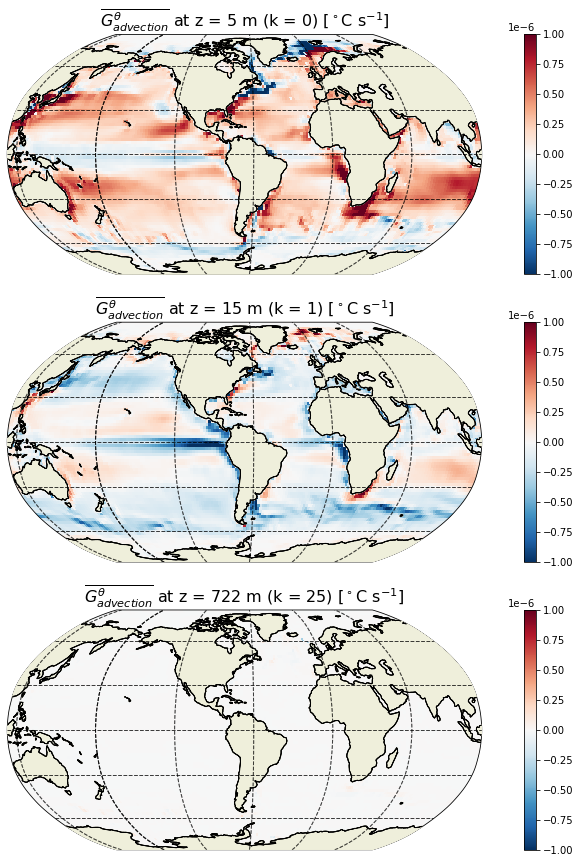

In [37]:
plt.figure(figsize=(15,15))

for idx, k in enumerate([0,1,25]):
    p = ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, G_advection_mean[:,k],show_colorbar=True,
                                      cmin=-1e-6, cmax=1e-6, cmap='RdBu_r', user_lon_0=-67, dx=2, dy=2, 
                                      subplot_grid=[3,1,idx+1]);
    p[1].set_title(r'$\overline{G^\theta_{advection}}$ at z = %i m (k = %i) [$^\circ$C s$^{-1}$]'\
                   %(np.round(-ecco_grid.Z[k].values),k), fontsize=16)

### Example $G^{\theta}_\textrm{advection}$ field at a particular time

(2001, 5, 16, 12, 0, 0)


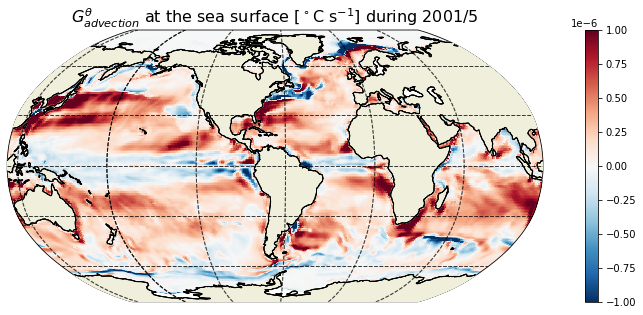

In [38]:
plt.figure(figsize=(15,5));

tmp = ecco.extract_yyyy_mm_dd_hh_mm_ss_from_datetime64(G_advection.time[100].values)
print(tmp)

ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, G_advection.isel(time=100)[:,0],show_colorbar=True,
                              cmin=-1e-6, cmax=1e-6, cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2)
plt.title(r'$G^\theta_{advection}$ at the sea surface [$^\circ$C s$^{-1}$] during ' + 
          str(tmp[0]) +'/' + str(tmp[1]), fontsize=16)
plt.show()

## Calculate tendency due to diffusive convergence ($G^{\theta}_\textrm{diffusion}$)
### Horizontal convergence of advective heat flux
The relevant fields from the diagnostic output here are
- `DFxE_TH`: U Component Diffusive Flux of Potential Temperature (degC m^3/s)
- `DFyE_TH`: V Component Diffusive Flux of Potential Temperature (degC m^3/s)

As with advective fluxes, we use the xgcm `grid` object to calculate the convergence of horizontal heat diffusion.

In [39]:
DFxyE_diff = grid.diff_2d_vector({'X' : ecco_monthly_mean.DFxE_TH, 'Y' : ecco_monthly_mean.DFyE_TH}, 
                                 boundary = 'fill')

# Convergence of horizontal diffusion (degC m^3/s)
dif_hConvH = (-(DFxyE_diff['X'] + DFxyE_diff['Y']))

### Vertical convergence of advective heat flux
The relevant fields from the diagnostic output are
- `DFrE_TH`: Vertical Diffusive Flux of Potential Temperature (Explicit part) (degC m^3/s)
- `DFrI_TH`: Vertical Diffusive Flux of Potential Temperature (Implicit part) (degC m^3/s)
> **Note**: Vertical diffusion has both an explicit (`DFrE_TH`) and an implicit (`DFrI_TH`) part.

In [40]:
# Load monthly averages of vertical diffusive fluxes
DFrE_TH = ecco_monthly_mean.DFrE_TH.transpose('time','tile','k_l','j','i')
DFrI_TH = ecco_monthly_mean.DFrI_TH.transpose('time','tile','k_l','j','i')

# Convergence of vertical diffusion (degC m^3/s)
dif_vConvH = grid.diff(DFrE_TH, 'Z', boundary='fill') + grid.diff(DFrI_TH, 'Z', boundary='fill')

### Total convergence of diffusive flux ($G^{\theta}_\textrm{diffusion}$)

In [41]:
# Sum horizontal and vertical convergences and divide by volume (degC/s)
G_diffusion = (dif_hConvH + dif_vConvH)/vol

### Plot the time-mean $G^{\theta}_\textrm{diffusion}$

In [42]:
G_diffusion_mean = (G_diffusion*month_length_weights).sum('time')

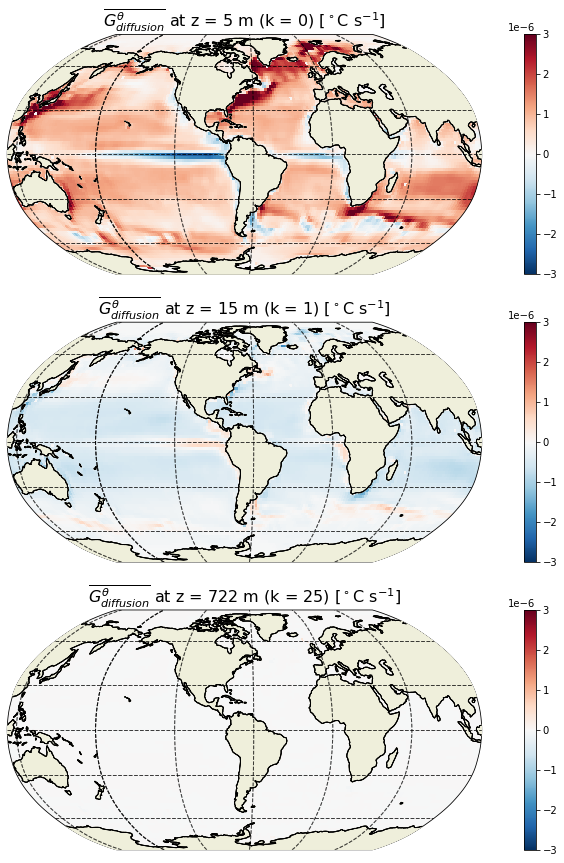

In [43]:
plt.figure(figsize=(15,15))

for idx, k in enumerate([0,1,25]):
    p = ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, G_diffusion_mean[:,k],show_colorbar=True,
                                      cmin=-3e-6, cmax=3e-6, cmap='RdBu_r', user_lon_0=-67, dx=2, dy=2, 
                                      subplot_grid=[3,1,idx+1]);
    p[1].set_title(r'$\overline{G^\theta_{diffusion}}$ at z = %i m (k = %i) [$^\circ$C s$^{-1}$]'\
                   %(np.round(-ecco_grid.Z[k].values),k), fontsize=16)

### Example $G^{\theta}_\textrm{diffusion}$ field at a particular time

(2001, 5, 16, 12, 0, 0)


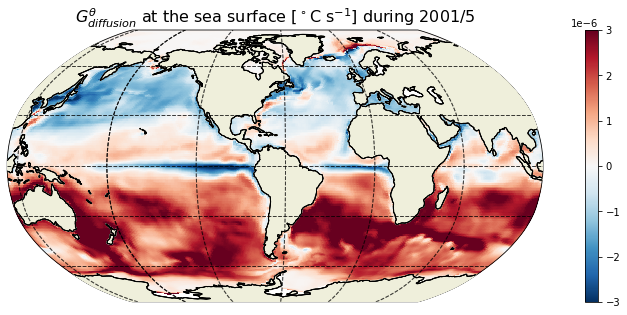

In [44]:
plt.figure(figsize=(15,5));

tmp = ecco.extract_yyyy_mm_dd_hh_mm_ss_from_datetime64(G_diffusion.time[100].values)
print(tmp)

ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, G_diffusion.isel(time=100)[:,0],show_colorbar=True,
                              cmin=-3e-6, cmax=3e-6, cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2)
plt.title(r'$G^\theta_{diffusion}$ at the sea surface [$^\circ$C s$^{-1}$] during ' + 
          str(tmp[0]) +'/' + str(tmp[1]), fontsize=16)
plt.show()

## Calculate tendency due to forcing ($G^{\theta}_\textrm{forcing}$)
Finally, we evaluate the local forcing term due to surface heat and geothermal fluxes.

### Surface heat flux
For the surface contribution, there are two relevant model diagnostics:
- `TFLUX`: total heat flux (match heat-content variations) (W/m^2)
- `oceQsw`: net Short-Wave radiation (+=down) (W/m^2)

#### Defining terms needed for evaluating surface heat forcing

In [45]:
Z = ecco_grid.Z.load()
RF = np.concatenate([ecco_grid.Zp1.values[:-1],[np.nan]])

>**Note**: `Z` and `Zp1` are used in deriving surface heat penetration. MATLAB code uses `RF` from `mygrid` structure.

In [46]:
q1 = R*np.exp(1.0/zeta1*RF[:-1]) + (1.0-R)*np.exp(1.0/zeta2*RF[:-1])
q2 = R*np.exp(1.0/zeta1*RF[1:]) + (1.0-R)*np.exp(1.0/zeta2*RF[1:])

In [47]:
# Correction for the 200m cutoff
zCut = np.where(Z < -200)[0][0]
q1[zCut:] = 0
q2[zCut-1:] = 0

In [48]:
# Save q1 and q2 as xarray data arrays
q1 = xr.DataArray(q1,coords=[Z.k],dims=['k'])
q2 = xr.DataArray(q2,coords=[Z.k],dims=['k'])

#### Compute vertically penetrating flux
Given the penetrating nature of the shortwave term, to properly evaluate the local forcing term, `oceQsw` must be removed from `TFLUX` (which contains the net latent, sensible, longwave, and shortwave contributions) and redistributed vertically.

In [49]:
## Land masks
# Make copy of hFacC
mskC = ecco_grid.hFacC.copy(deep=True).load()

# Change all fractions (ocean) to 1. land = 0
mskC.values[mskC.values>0] = 1

In [50]:
# Shortwave flux below the surface (W/m^2)
forcH_subsurf = ((q1*(mskC==1)-q2*(mskC.shift(k=-1)==1))\
                 *ecco_monthly_mean.oceQsw).transpose('time','tile','k','j','i')

In [51]:
# Surface heat flux (W/m^2)
forcH_surf = ((ecco_monthly_mean.TFLUX - (1-(q1[0]-q2[0]))\
               *ecco_monthly_mean.oceQsw)\
              *mskC[0]).transpose('time','tile','j','i').assign_coords(k=0).expand_dims('k')

In [52]:
# Full-depth sea surface forcing (W/m^2)
forcH = xr.concat([forcH_surf,forcH_subsurf[:,:,1:]], dim='k').transpose('time','tile','k','j','i')

### Geothermal flux

The geothermal flux contribution is not accounted for in any of the standard model diagnostics provided as output. Rather, this term, which is time invariant, is provided in the input file `geothermalFlux.bin` and can be downloaded from the PO.DAAC drive (https://ecco.jpl.nasa.gov/drive/files/Version4/Release3/input_init/geothermalFlux.bin).
> **Note**: Here, `geothermalFlux.bin` has been placed in `base_dir`.

In [53]:
# Load the geothermal heat flux using the routine 'read_llc_to_tiles'
geoflx = ecco.read_llc_to_tiles(base_dir, 'geothermalFlux.bin')

The geothermal flux dataset needs to be saved as an xarray data array with the same format as the model output.

In [56]:
# Convert numpy array to an xarray DataArray with matching dimensions as the monthly mean fields
geoflx_llc = xr.DataArray(geoflx,coords={'tile': ecco_monthly_mean.tile.values,
                                         'j': ecco_monthly_mean.j.values,
                                         'i': ecco_monthly_mean.i.values},dims=['tile','j','i'])

In [ ]:
plt.figure(figsize=(15,5));

ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, geoflx_llc,show_colorbar=True,cmap='magma', 
                              user_lon_0=-67, dx=0.2, dy=0.2)
plt.title(r'Geothermal heat flux [W m$^{-2}$]', fontsize=16)
plt.show()

Geothermal flux needs to be a three dimensional field since the sources are distributed along the ocean floor at various depths. This requires a three dimensional mask.

In [57]:
# Create 3d bathymetry mask
mskC_shifted = mskC.shift(k=-1)

mskC_shifted.values[-1,:,:,:] = 0
mskb = mskC - mskC_shifted

# Create 3d field of geothermal heat flux
geoflx3d = geoflx_llc * mskb.transpose('k','tile','j','i')
GEOFLX = geoflx3d.transpose('k','tile','j','i')
GEOFLX.attrs = {'standard_name': 'GEOFLX','long_name': 'Geothermal heat flux','units': 'W/m^2'}

### Total forcing ($G^{\theta}_\textrm{forcing}$)

In [58]:
# Add geothermal heat flux to forcing field and convert from W/m^2 to degC/s
G_forcing = ((forcH + GEOFLX)/(rhoconst*c_p))/(ecco_grid.hFacC*ecco_grid.drF)

### Plot the time-mean $G^{\theta}_\textrm{forcing}$

In [59]:
G_forcing_mean = (G_forcing*month_length_weights).sum('time')

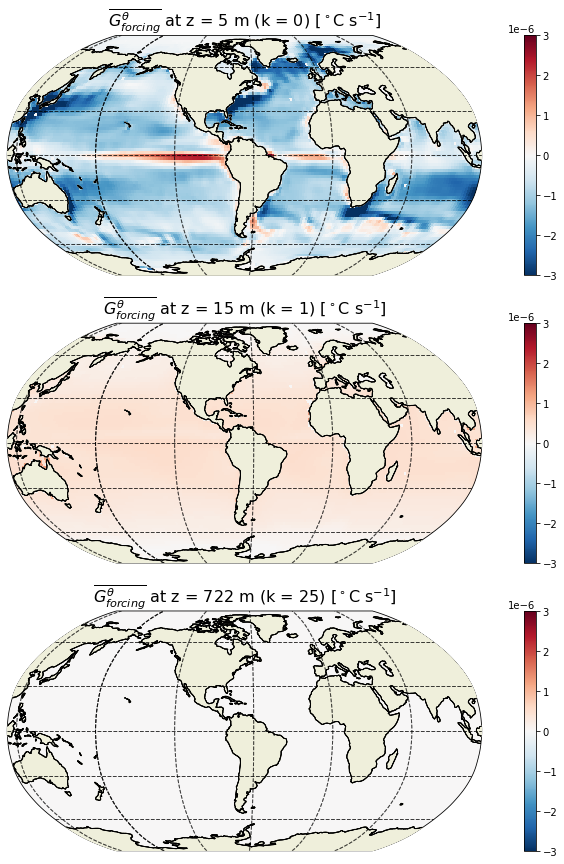

In [60]:
plt.figure(figsize=(15,15))

for idx, k in enumerate([0,1,25]):
    p = ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, G_forcing_mean[:,k],show_colorbar=True,
                                      cmin=-3e-6, cmax=3e-6, cmap='RdBu_r', user_lon_0=-67, dx=2, dy=2, 
                                      subplot_grid=[3,1,idx+1]);
    p[1].set_title(r'$\overline{G^\theta_{forcing}}$ at z = %i m (k = %i) [$^\circ$C s$^{-1}$]'\
                   %(np.round(-ecco_grid.Z[k].values),k), fontsize=16)

$\overline{G^\theta_{forcing}}$ is focused at the sea surface and much smaller (essentially zero) at depth. $\overline{G^\theta_{forcing}}$ is negative for most of the ocean (away from the equator). The spatial pattern in the surface forcing is the same as for diffusion but with opposite sign (see maps for $\overline{G^\theta_{diffusion}}$ above). This makes sense as forcing is to a large extent balanced by diffusion within the mixed layer.

### Example $G^{\theta}_\textrm{forcing}$ field at a particular time

(2001, 5, 16, 12, 0, 0)


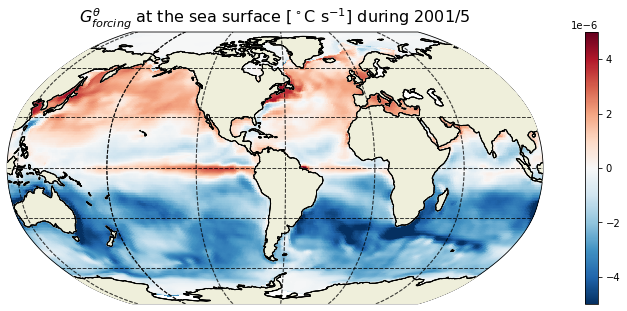

In [61]:
plt.figure(figsize=(15,5));

tmp = ecco.extract_yyyy_mm_dd_hh_mm_ss_from_datetime64(G_forcing.time[100].values)
print(tmp)

ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, G_forcing.isel(time=100)[:,0],show_colorbar=True,
                              cmin=-5e-6, cmax=5e-6, cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2)
plt.title(r'$G^\theta_{forcing}$ at the sea surface [$^\circ$C s$^{-1}$] during ' + 
          str(tmp[0]) +'/' + str(tmp[1]), fontsize=16)
plt.show()

## Save to dataset
Now that we have all the terms evaluated, let's save them to a dataset. Here are two examples:
- Zarr is a new format that is used for cloud storage.
- Netcdf is the more traditional format that most people are familiar with.

### Add all variables to a new dataset

In [69]:
varnames = ['G_total_tendency','G_advection','G_diffusion','G_forcing']

ds = xr.Dataset(data_vars={})
for varname in varnames:
    ds[varname] = globals()[varname].chunk(chunks={'time':1,'tile':13,'k':50,'j':90,'i':90})

In [70]:
# Add surface forcing (degC/s)
ds['Qnet'] = ((forcH /(rhoconst*c_p))/(ecco_grid.hFacC*ecco_grid.drF)).chunk(chunks={'time':1,'tile':13,
                                                                                     'k':50,'j':90,'i':90})

In [73]:
ds.time.encoding = {}
ds = ds.reset_coords(drop=True)

### Save to zarr

In [67]:
from dask.diagnostics import ProgressBar

In [77]:
with ProgressBar():
    ds.to_zarr(base_dir + '/eccov4r3_budg_heat')

[########################################] | 100% Completed |  6min 35.4s


### Save to netcdf

In [70]:
with ProgressBar():
    ds.to_netcdf(base_dir + '/eccov4r3_budg_heat.nc', format='NETCDF4')

[########################################] | 100% Completed | 14min 17.5s


## Load budget variables from file
After having saved the budget terms to file, let's restart the kernel and load only the relevant data and Python modules.

In [1]:
# Suppress warning messages for a cleaner presentation
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import xarray as xr
import ecco_v4_py as ecco

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
base_dir = '/home/username/ECCOv4-release'
ECCO_dir = base_dir + '/Release3_alt'
grid_dir= ECCO_dir + '/nctiles_grid/'
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc')

In [4]:
# Load terms from zarr dataset
G_total_tendency = xr.open_zarr(base_dir + '/eccov4r3_budg_heat').G_total_tendency
G_advection = xr.open_zarr(base_dir + '/eccov4r3_budg_heat').G_advection
G_diffusion = xr.open_zarr(base_dir + '/eccov4r3_budg_heat').G_diffusion
G_forcing = xr.open_zarr(base_dir + '/eccov4r3_budg_heat').G_forcing
Qnet = xr.open_zarr(base_dir + '/eccov4r3_budg_heat').Qnet

## Comparison between LHS and RHS of the budget equation

In [5]:
# Total convergence
ConvH = G_advection + G_diffusion

In [6]:
# Sum of terms in RHS of equation
rhs = ConvH + G_forcing

### Map of residuals

In [7]:
res = (rhs-G_total_tendency).sum(dim='k').sum(dim='time').compute()

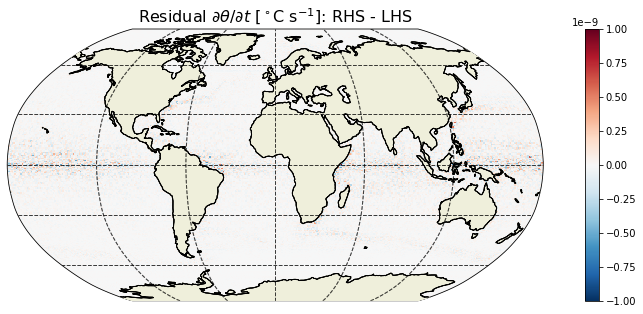

In [8]:
plt.figure(figsize=(15,5))
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, res,
                              cmin=-1e-9, cmax=1e-9, show_colorbar=True, cmap='RdBu_r',dx=0.2, dy=0.2)
plt.title(r'Residual $\partial \theta / \partial t$ [$^\circ$C s$^{-1}$]: RHS - LHS', fontsize=16)
plt.show()

The residual (summed over depth and time) is essentially zero everywhere. What if we omit the geothermal heat flux?

In [9]:
res_geo = (ConvH + Qnet - G_total_tendency).sum(dim='k').sum(dim='time').compute()

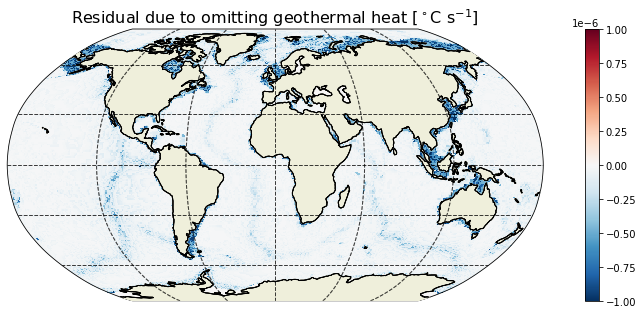

In [10]:
plt.figure(figsize=(15,5))
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, res_geo,
                              cmin=-1e-6, cmax=1e-6, show_colorbar=True, cmap='RdBu_r', dx=0.2, dy=0.2)
plt.title(r'Residual due to omitting geothermal heat [$^\circ$C s$^{-1}$] ', fontsize=16)
plt.show()

We see that the contribution from geothermal flux in the heat budget is well above the residual (by *three orders of magnitude*).

### Histogram of residuals
We can look at the distribution of residuals to get a little more confidence.

In [11]:
tmp = np.abs(rhs-G_total_tendency).values.ravel()

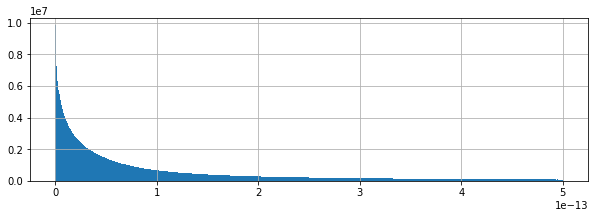

In [12]:
plt.figure(figsize=(10,3));

plt.hist(tmp[np.nonzero(tmp > 0)],np.linspace(0, .5e-12,1000));
plt.grid()

Almost all residuals < $10^{-13}$ $^\circ$C s$^{-1}$.

In [13]:
tmp = np.abs(res).values.ravel()

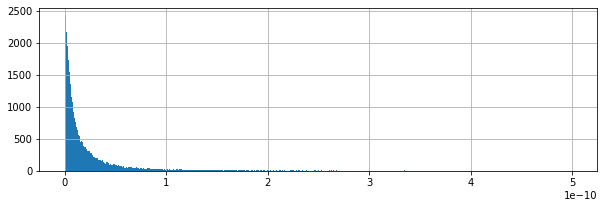

In [14]:
plt.figure(figsize=(10,3));

plt.hist(tmp[np.nonzero(tmp > 0)],np.linspace(0, .5e-9,1000));
plt.grid()

Summing residuals vertically and temporally yields < $10^{-10}$ $^\circ$C s$^{-1}$ for most grid points.

## Heat budget closure through time

### Global average budget closure

Another way of demonstrating heat budget closure is to show the global spatially-averaged `THETA` tendency terms 

In [15]:
# Volume (m^3)
vol = (ecco_grid.rA*ecco_grid.drF*ecco_grid.hFacC).transpose('tile','k','j','i')

# Take volume-weighted mean of these terms
tmp_a=(G_total_tendency*vol).sum(dim=('k','i','j','tile'))/vol.sum()
tmp_b=(G_advection*vol).sum(dim=('k','i','j','tile'))/vol.sum()
tmp_c=(G_diffusion*vol).sum(dim=('k','i','j','tile'))/vol.sum()
tmp_d=(G_forcing*vol).sum(dim=('k','i','j','tile'))/vol.sum()
tmp_e=(rhs*vol).sum(dim=('k','i','j','tile'))/vol.sum()

# Result is five time series
tmp_a.dims

('time',)

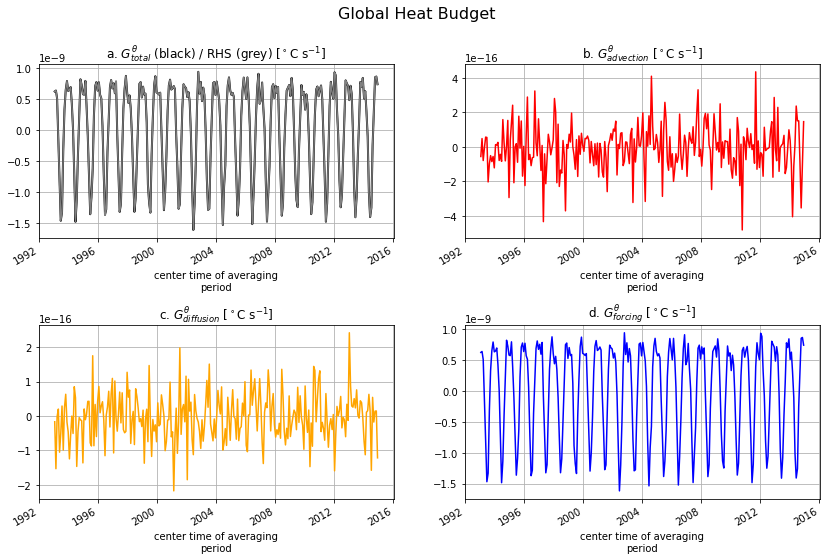

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(14,8))

plt.sca(axs[0,0])
tmp_a.plot(color='k',lw=2)
tmp_e.plot(color='grey')
axs[0,0].set_title(r'a. $G^\theta_{total}$ (black) / RHS (grey) [$^\circ$C s$^{-1}$]', fontsize=12)
plt.grid()

plt.sca(axs[0,1])
tmp_b.plot(color='r')
axs[0,1].set_title(r'b. $G^\theta_{advection}$ [$^\circ$C s$^{-1}$]', fontsize=12)
plt.grid()

plt.sca(axs[1,0])
tmp_c.plot(color='orange')
axs[1,0].set_title(r'c. $G^\theta_{diffusion}$ [$^\circ$C s$^{-1}$]', fontsize=12)
plt.grid()

plt.sca(axs[1,1])
tmp_d.plot(color='b')
axs[1,1].set_title(r'd. $G^\theta_{forcing}$ [$^\circ$C s$^{-1}$]', fontsize=12)
plt.grid()
plt.subplots_adjust(hspace = .5, wspace=.2)
plt.suptitle('Global Heat Budget', fontsize=16);

When averaged over the entire ocean the ocean heat transport terms ($G^\theta_\textrm{advection}$ and $G^\theta_\textrm{diffusion}$)  have no net impact on $G^\theta_\textrm{total}$ (i.e., $\partial \theta / \partial t$).  This makes sence because $G^\theta_\textrm{advection}$ and $G^\theta_\textrm{diffusion}$ can only redistributes heat. Globally, $\theta$ can only change via $G^\theta_\textrm{forcing}$.

### Local heat budget closure

Locally we expect that heat divergence can impact $\theta$. This is demonstrated for a single grid point.

In [17]:
# Pick any set of indices (tile, k, j, i) corresponding to an ocean grid point
t,k,j,i = (6,10,40,29)
print(t,k,j,i)

6 10 40 29


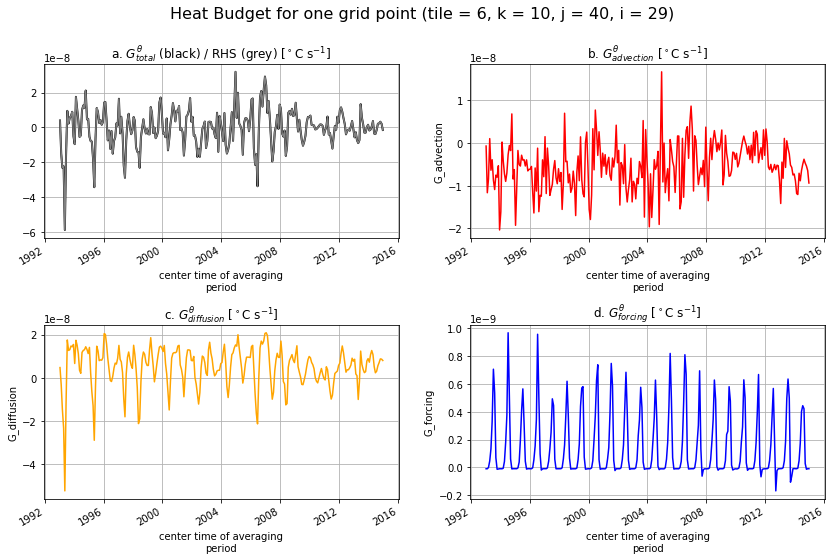

In [18]:
tmp_a = G_total_tendency.isel(tile=t,k=k,j=j,i=i)
tmp_b = G_advection.isel(tile=t,k=k,j=j,i=i)
tmp_c = G_diffusion.isel(tile=t,k=k,j=j,i=i)
tmp_d = G_forcing.isel(tile=t,k=k,j=j,i=i)
tmp_e = rhs.isel(tile=t,k=k,j=j,i=i)

fig, axs = plt.subplots(2, 2, figsize=(14,8))

plt.sca(axs[0,0])
tmp_a.plot(color='k',lw=2)
tmp_e.plot(color='grey')
axs[0,0].set_title(r'a. $G^\theta_{total}$ (black) / RHS (grey) [$^\circ$C s$^{-1}$]', fontsize=12)
plt.grid()

plt.sca(axs[0,1])
tmp_b.plot(color='r')
axs[0,1].set_title(r'b. $G^\theta_{advection}$ [$^\circ$C s$^{-1}$]', fontsize=12)
plt.grid()

plt.sca(axs[1,0])
tmp_c.plot(color='orange')
axs[1,0].set_title(r'c. $G^\theta_{diffusion}$ [$^\circ$C s$^{-1}$]', fontsize=12)
plt.grid()

plt.sca(axs[1,1])
tmp_d.plot(color='b')
axs[1,1].set_title(r'd. $G^\theta_{forcing}$ [$^\circ$C s$^{-1}$]', fontsize=12)
plt.grid()
plt.subplots_adjust(hspace = .5, wspace=.2)
plt.suptitle('Heat Budget for one grid point (tile = %i, k = %i, j = %i, i = %i)'%(t,k,j,i), fontsize=16);

Indeed, the heat divergence terms do contribute to $\theta$ variations at a single point. Local heat budget closure is also confirmed at this grid point as we see that the sum of terms on the RHS (grey line) equals the LHS (black line).

For the Arctic grid point, there is a clear seasonal cycles in both $G^\theta_\textrm{total}$, $G^\theta_\textrm{diffusion}$ and $G^\theta_\textrm{forcing}$. The seasonal cycle in $G^\theta_\textrm{forcing}$ seems to be the reverse of $G^\theta_\textrm{total}$ and $G^\theta_\textrm{diffusion}$.

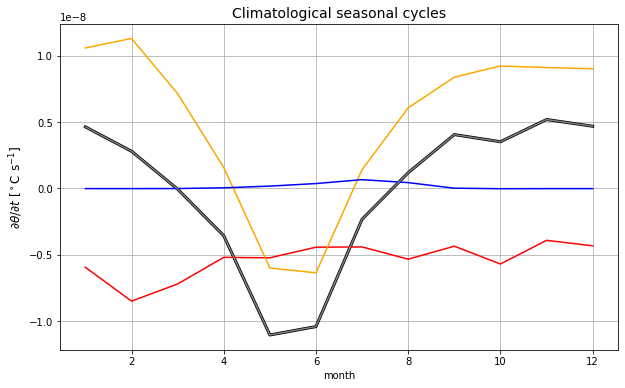

In [19]:
plt.figure(figsize=(10,6));
tmp_a.groupby('time.month').mean('time').plot(color='k',lw=3)
tmp_b.groupby('time.month').mean('time').plot(color='r')
tmp_c.groupby('time.month').mean('time').plot(color='orange')
tmp_d.groupby('time.month').mean('time').plot(color='b')
tmp_e.groupby('time.month').mean('time').plot(color='grey')
plt.ylabel(r'$\partial\theta$/$\partial t$ [$^\circ$C s$^{-1}$]', fontsize=12)
plt.grid()
plt.title('Climatological seasonal cycles', fontsize=14)
plt.show()

The mean seasonal cycle of the total is driven by seasonality in diffusion. However, this is likely depth-dependent. How does the balance look across the upper 200 meter at that location?

## Time-mean vertical profiles

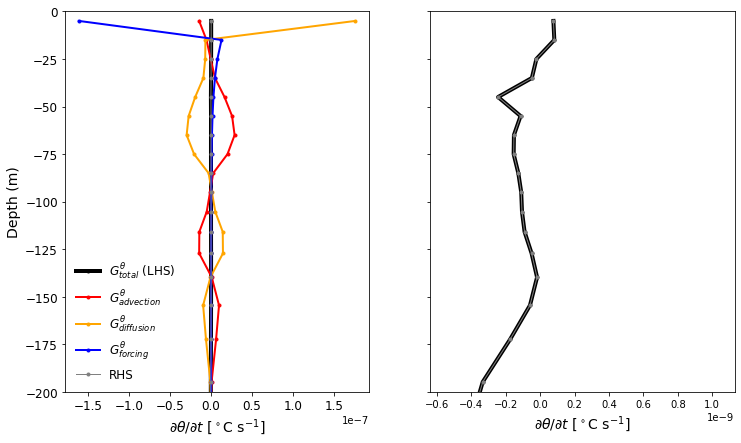

In [24]:
fig = plt.subplots(1, 2, sharey=True, figsize=(12,7))

plt.subplot(1, 2, 1)
plt.plot(G_total_tendency.isel(tile=t,j=j,i=i).mean('time'), ecco_grid.Z,
         lw=4, color='black', marker='.', label=r'$G^\theta_{total}$ (LHS)')

plt.plot(G_advection.isel(tile=t,j=j,i=i).mean('time'), ecco_grid.Z, 
         lw=2, color='red', marker='.', label=r'$G^\theta_{advection}$')

plt.plot(G_diffusion.isel(tile=t,j=j,i=i).mean('time'), ecco_grid.Z, 
         lw=2, color='orange', marker='.', label=r'$G^\theta_{diffusion}$')

plt.plot(G_forcing.isel(tile=t,j=j,i=i).mean('time'), ecco_grid.Z, 
         lw=2, color='blue', marker='.', label=r'$G^\theta_{forcing}$')
plt.plot(rhs.isel(tile=t,j=j,i=i).mean('time'), ecco_grid.Z, lw=1, color='grey', marker='.', label='RHS')
plt.xlabel(r'$\partial\theta$/$\partial t$ [$^\circ$C s$^{-1}$]', fontsize=14)
plt.ylim([-200,0])
plt.ylabel('Depth (m)', fontsize=14)
plt.gca().tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc='lower left', frameon=False, fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(G_total_tendency.isel(tile=t,j=j,i=i).mean('time'), ecco_grid.Z,
         lw=4, color='black', marker='.', label=r'$G^\theta_{total}$ (LHS)')
plt.plot(rhs.isel(tile=t,j=j,i=i).mean('time'), ecco_grid.Z, lw=1, color='grey', marker='.', label='RHS')
plt.setp(plt.gca(), 'yticklabels',[])
plt.xlabel(r'$\partial\theta$/$\partial t$ [$^\circ$C s$^{-1}$]', fontsize=14)
plt.ylim([-200,0])
plt.show()

Balance between surface forcing and diffusion in the top layers. Balance between advection and diffusion at depth.